In [1]:
#Import library 
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
import seaborn as sns
import seaborn as sn


import seaborn; seaborn.set_style('whitegrid')
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OrdinalEncoder

#from aif360.datasets import StandardDataset
#from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

%matplotlib inline

from pomegranate import *
import pygraphviz
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)
from sklearn.model_selection import train_test_split
import networkx
from pomegranate.utils import plot_networkx


In [5]:
def statistical_parity_difference(dataset, protected,classes,majority_group,minority_group,positive_value):
    ratio = round(pd.crosstab(dataset[protected], dataset[classes]).div(pd.crosstab(dataset[protected], dataset[classes]).apply(sum,1),0),4)*100
    #return ratio
    return ratio.loc[majority_group][positive_value]-ratio.loc[minority_group][positive_value]

In [6]:
def basic_info(dataset,class_label,positive_value,negative_value,protected_attr,majority_group,minority_group):
    categorical_columns = (dataset.select_dtypes(['category', 'object']).columns)
    numeric_columns = (dataset.select_dtypes(['number']).columns)
    for attr in dataset.keys():
        if attr in categorical_columns:    
            print(attr ,' & Categorical & ',len(dataset[attr].value_counts()),'& &',dataset[attr].isnull().sum(),'\\\\')
        else:           
            print(attr,'& Numerical &',len(dataset[attr].value_counts()),'&',min(dataset[attr]),"-",max(dataset[attr]),'&',dataset[attr].isnull().sum(),'\\\\')  
    
    print('Class distribution:',dataset[class_label].value_counts())
    print('Class imbalance:',len(dataset.loc[dataset[class_label]==negative_value])/len(dataset.loc[dataset[class_label]==positive_value]))
    print('statistical parity:',statistical_parity_difference(dataset,protected_attr,class_label,majority_group,minority_group,positive_value))

In [7]:
def german_credit():
  df=pd.read_csv("data/german_data_credit.csv")
  print("Length:",len(df))
  print("Number of attribute:",len(df.columns))

  Status_of_existing_checking_account={"no account": "A14","<0 DM": 'A11', "0 <= <200 DM": 'A12',">= 200 DM ": 'A13'}
  df["checking-account"]=df["checking-account"].map(Status_of_existing_checking_account)

  Credit_history={"critical account": "A34","delay in paying off": "A33","existing credits paid back duly till now": "A32","all credits at this bank paid back duly": "A31","no credits taken": "A30"}
  df["credit-history"]=df["credit-history"].map(Credit_history)

  Purpose={"car (new)": "A40", "car (used)": "A41", "furniture/equipment": "A42", "radio/television": "A43" , "domestic appliances": "A44",  "repairs": "A45", "education": "A46", 'vacation': 'A47', 'retraining': "A48",'business': "A49", 'others': "A410"}
  df["purpose"]=df["purpose"].map(Purpose)

  Saving_account={"no savings account": "A65","<100 DM": "A61","100 <= <500 DM": "A62","500 <= < 1000 DM": "A63", ">= 1000 DM": "A64"}
  df["savings-account"]=df["savings-account"].map(Saving_account)

  Present_employment={">=7 years": "A75", "4<= <7 years": "A74",  "1<= < 4 years": "A73", "<1 years": "A72","unemployed": "A71"}
  df["employment-since"]=df["employment-since"].map(Present_employment)


  #Personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
  #df["personal-status-and-sex"]=df["personal-status-and-sex"].map(Personal_status_and_sex)

  #sex={ 'A95':"female",'A94':"male",'A93':"male", 'A92':"female", 'A91':"male"}
  # df["sex"]=['male' if (v=='A94' or v =='A93' or v == 'A91') else 'female' for v in df['personal-status-and-sex']]


  Other_debtors_guarantors={"none":'A101', "co-applicant":'A102', "guarantor":'A103'}
  df["other-debtors"]=df["other-debtors"].map(Other_debtors_guarantors)


  Property={"real estate":'A121', "savings agreement/life insurance":'A122', "car or other":'A123', "unknown / no property":'A124'}
  df["property"]=df["property"].map(Property)



  Other_installment_plans={"none":'A143', "store":'A142', "bank":'A141'}
  df["other-installment"]=df["other-installment"].map(Other_installment_plans)

  Housing={"for free":'A153', "own":'A152', "rent":'A151'}
  df["housing"]=df["housing"].map(Housing)



  Job={"management/ highly qualified employee":'A174', "skilled employee / official":'A173', "unskilled - resident":'A172', "unemployed/ unskilled  - non-resident":'A171'}
  df["job"]=df["job"].map(Job)

  Telephone={"yes":'A192', "none":'A191'}
  df["telephone"]=df["telephone"].map(Telephone)


  foreign_worker={"yes":'A201', "no":'A202'}
  df["foreign-worker"]=df["foreign-worker"].map(foreign_worker)

  risk={1:"Good", 2:"Bad"}
  df["class-label"]=df["class-label"].map(risk)

  # basic_info(df,class_label="class-label",positive_value="Good",negative_value="Bad",
  #          protected_attr="sex",majority_group='male',minority_group='female')
  
  print(df['class-label'].value_counts())

  X = df.values
  for i in range(len(list(df.keys()))):
    if len(pd.unique(df[df.keys()[i]])) == 2:
      print(i,list(df.keys())[i], len(pd.unique(df[df.keys()[i]]))) 
  labels=list(df.keys())
  # labels = list(map(str, range(len(list(df.keys())))))
  
  #Encode
  X[:,1]=np.array([0 if v<=6 else 1 if v>6 and v<=12 else 2 for v in X[:,1]]) #duration
  X[:,4]=np.array([0 if v<=2000 else 1 if v>2000 and v<=5000 else 2 for v in X[:,4]]) #credit amount
  X[:,11]=np.array([0 if v<25 else 1 for v in X[:,11]]) #age
  
  # a = networkx.DiGraph()
  # b = tuple((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
  # c= tuple((21,))
  # a.add_edge(b,c)
  # a.add_edge(b,b)
  # return a, X, labels 

In [8]:
def credit_scoring():
  df=pd.read_csv("data/credit_scoring.csv")
  df = df.replace({'-':0})
  print("Length:",len(df))
  print("Number of attribute:",len(df.columns))
  
  df['INPS_mln_sum']=df['INPS_mln_sum'].astype(float) 
  df['Score_point']=df['Score_point'].astype(float) 
  df['Score_class']=df['Score_class'].astype(float) 
  df['Score_level']=df['Score_level'].astype(float) 

  inps_mln_sum_med =df['INPS_mln_sum'].median() 
  X = df.values

  print(df['label'].value_counts())
  for i in range(len(list(df.keys()))):
    if len(pd.unique(df[df.keys()[i]])) == 2:
      print(i,list(df.keys())[i], len(pd.unique(df[df.keys()[i]]))) 
  # labels=list(df.keys())
  X[:, 1]=np.array([0 if v<25 else 1 for v in X[:,1]]) #age
  X[:, 16]=np.array([0 if v==0 else 1 for v in X[:, 16]]) # score point
  X[:, 15]=np.array([0 if v==0 else 1 for v in X[:, 15]]) # score level 
  X[:, 14]=np.array([0 if v==0 else 1 for v in X[:, 14]]) # score class
  X[:, 12]=np.array([0 if v<= inps_mln_sum_med else 1 for v in X[:, 12]]) # score class

  # a = networkx.DiGraph()
  # b = tuple((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17))
  # c= tuple((0,))
  # a.add_edge(b,c)
  # a.add_edge(b,b)

  # return a, X, labels

In [9]:
credit_scoring()

Length: 8755
Number of attribute: 18
1    8059
0     696
Name: label, dtype: int64
0 label 2
2 Language 2
3 Sex 2
5 Has_Credit 2
8 Day_of_birth 2
13 INPS_yes_no 2


In [10]:
def credit_approval():
  df=pd.read_csv('data/credit-approval.data',sep=",")
  
  
  df=df[df['Male'] != '?']   
  df=df.replace({'?': None})
  df=df.drop(columns=['ZipCode'])
  df=df.dropna()
  df['Age']=df['Age'].astype(float) 
  debt_med = df['Debt'].median()
  year_employed_med =df['YearsEmployed'].median() 
  credit_score_med =df['CreditScore'].median()
  income_med =df['Income'].median()

  # print("Length:",len(df))
  # print("Number of attribute:",len(df.columns))
  
  #Label sex
  df['Male']=["Female" if v == "a" else "Male" for v in df['Male']]
  # print(debt_med, year_employed_med, credit_score_med, income_med)
  print(df['Approved'].value_counts())
  #Label class
  df['Approved']=[1 if v == "+" else 0 for v in df['Approved']]

  X = df.values
  for i in range(len(list(df.keys()))):
    if len(pd.unique(df[df.keys()[i]])) == 2:
      print(i,list(df.keys())[i], len(pd.unique(df[df.keys()[i]]))) 
  labels=list(df.keys())

  X[:, 1]=np.array([0 if v<25 else 1 for v in X[:,1]]) #age
  X[:, 2]=np.array([0 if v<=debt_med else 1 for v in X[:,2]]) #debt
  X[:, 7]=np.array([0 if v<=year_employed_med else 1 for v in X[:,7]]) #years employed
  X[:, 10]=np.array([0 if v<=credit_score_med else 1 for v in X[:,10]]) #credit score
  X[:, 13]=np.array([0 if v<=income_med else 1 for v in X[:,13]]) #income

  a = networkx.DiGraph()
  b = tuple((0,1,2,3,4,5,6,7,8,9,10,11,12,13))
  c= tuple((14,))
  a.add_edge(b,c)
  a.add_edge(b,b)

  return a, X, labels

In [11]:
def credit_card():
  df = pd.read_csv('data/credit-card-clients.csv') 

  X = df.values
  for i in range(len(list(df.keys()))):
    if len(pd.unique(df[df.keys()[i]])) == 2:
      print(i,list(df.keys())[i], len(pd.unique(df[df.keys()[i]]))) 
  labels=list(df.keys())

  print("Length:",len(df))
  print("Number of attribute:",len(df.columns))

  limit_ball_med = df['LIMIT_BAL'].median()

  bill_amt_1_med = df['BILL_AMT1'].median()
  bill_amt_2_med = df['BILL_AMT2'].median()
  bill_amt_3_med = df['BILL_AMT3'].median()
  bill_amt_4_med = df['BILL_AMT4'].median()
  bill_amt_5_med = df['BILL_AMT5'].median()
  bill_amt_6_med = df['BILL_AMT6'].median()

  pay_amt_1_med = df['PAY_AMT1'].median()
  pay_amt_2_med = df['PAY_AMT2'].median()
  pay_amt_3_med = df['PAY_AMT3'].median()
  pay_amt_4_med = df['PAY_AMT4'].median()
  pay_amt_5_med = df['PAY_AMT5'].median()
  pay_amt_6_med = df['PAY_AMT6'].median()
  print(limit_ball_med)
  print(bill_amt_1_med, bill_amt_2_med, bill_amt_3_med, bill_amt_4_med, bill_amt_5_med, bill_amt_6_med)
  print(pay_amt_1_med, pay_amt_2_med, pay_amt_3_med, pay_amt_4_med, pay_amt_5_med, pay_amt_6_med)
  print(df['default payment'].value_counts())
  # print(len(pd.unique(df['PAY_0'])))

  X[:, 0]=np.array([0 if v<limit_ball_med else 1 for v in X[:,0]]) 
  X[:, 4]=np.array([0 if v<25 else 1 for v in X[:,4]]) 
  X[:, 5]=np.array([0 if v==-1 else 1 for v in X[:,5]]) 
  X[:, 6]=np.array([0 if v==-1 else 1 for v in X[:,6]]) 
  X[:, 7]=np.array([0 if v==-1 else 1 for v in X[:,7]]) 
  X[:, 8]=np.array([0 if v==-1 else 1 for v in X[:,8]]) 
  X[:, 9]=np.array([0 if v==-1 else 1 for v in X[:,9]]) 
  X[:, 10]=np.array([0 if v==-1 else 1 for v in X[:,10]]) 
  X[:, 11]=np.array([0 if v<=bill_amt_1_med else 1 for v in X[:,11]]) 
  X[:, 12]=np.array([0 if v<=bill_amt_2_med else 1 for v in X[:,12]]) 
  X[:, 13]=np.array([0 if v<=bill_amt_3_med else 1 for v in X[:,13]]) 
  X[:, 14]=np.array([0 if v<=bill_amt_4_med else 1 for v in X[:,14]]) 
  X[:, 15]=np.array([0 if v<=bill_amt_5_med else 1 for v in X[:,15]]) 
  X[:, 16]=np.array([0 if v<=bill_amt_6_med else 1 for v in X[:,16]]) 
  X[:, 17]=np.array([0 if v<=pay_amt_1_med else 1 for v in X[:,17]]) 
  X[:, 18]=np.array([0 if v<=pay_amt_2_med else 1 for v in X[:,18]]) 
  X[:, 19]=np.array([0 if v<=pay_amt_3_med else 1 for v in X[:,19]]) 
  X[:, 20]=np.array([0 if v<=pay_amt_4_med else 1 for v in X[:,20]]) 
  X[:, 21]=np.array([0 if v<=pay_amt_5_med else 1 for v in X[:,21]]) 
  X[:, 22]=np.array([0 if v<=pay_amt_6_med else 1 for v in X[:,22]]) 

  # a = networkx.DiGraph()
  # b = tuple((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22))
  # c= tuple((23,))
  # a.add_edge(b,c)
  # a.add_edge(b,b)

  # return a, X, labels

In [17]:
def pakdd():
  df = pd.read_csv('data/PAKDD.csv') 

  df=df.drop(columns=['ID_CLIENT'])
  df =df.dropna()
  # 1 value: CLERK_TYPE, QUANT_ADDITIONAL_CARDS, EDUCATION_LEVEL, FLAG_MOBILE_PHONE, FLAG_HOME_ADDRESS_DOCUMENT, FLAG_RG, FLAG_CPF, FLAG_INCOME_PROOF, FLAG_ACSP_RECORD
  df=df.drop(columns = ['CLERK_TYPE', 'QUANT_ADDITIONAL_CARDS', 'EDUCATION_LEVEL', 'RESIDENCIAL_CITY', 'FLAG_MOBILE_PHONE', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_RG', 'FLAG_CPF', 'FLAG_INCOME_PROOF', 'FLAG_ACSP_RECORD'
                        ,'RESIDENCIAL_PHONE_AREA_CODE', 'RESIDENCIAL_BOROUGH', 'RESIDENCIAL_STATE', 'CITY_OF_BIRTH', 'PROFESSION_CODE'
                        , 'STATE_OF_BIRTH', 'RESIDENCIAL_PHONE_AREA_CODE','RESIDENCIAL_ZIP_3','PROFESSIONAL_ZIP_3'])
  df['SEX']=["Female" if v == "F" else "Male" for v in df['SEX']]

  print(len(df))
  X = df.values
  for i in range(len(list(df.keys()))):
    print(i,list(df.keys())[i], len(pd.unique(df[df.keys()[i]]))) 
  labels=list(df.keys())

  quant_dependants_med = df['QUANT_DEPENDANTS'].median()
  month_in_residence_med = df['MONTHS_IN_RESIDENCE'].median()
  personal_monthly_income_med = df['PERSONAL_MONTHLY_INCOME'].median()
  other_incomes_med = df['OTHER_INCOMES'].median()
  personal_assets_value_med = df['PERSONAL_ASSETS_VALUE'].median()
  month_in_the_job_med = df['MONTHS_IN_THE_JOB'].median()


  X[:, 0]=np.array([0 if v<20 else 1 for v in X[:,0]]) 
  X[:, 4]=np.array([0 if v<=quant_dependants_med else 1 for v in X[:,4]]) 
  X[:, 8]=np.array([0 if v<=month_in_residence_med else 1 for v in X[:,8]]) 
  X[:, 10]=np.array([0 if v<=personal_monthly_income_med else 1 for v in X[:,10]]) 
  X[:, 11]=np.array([0 if v<=other_incomes_med else 1 for v in X[:,11]]) 
  X[:, 17]=np.array([0 if v==0 else 1 for v in X[:,17]]) 
  X[:, 18]=np.array([0 if v==0 else 1 for v in X[:,18]]) 
  X[:, 19]=np.array([0 if v<=personal_assets_value_med else 1 for v in X[:,19]]) 
  X[:, 23]=np.array([0 if v<=month_in_the_job_med else 1 for v in X[:,23]])
  X[:, 24]=np.array([0 if v==0 else 1 for v in X[:,24]]) 
  X[:, 26]=np.array([0 if v<=25 else 1 for v in X[:,26]]) 

  a = networkx.DiGraph()
  b = tuple((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26))
  c= tuple((27,))
  a.add_edge(b,c)
  a.add_edge(b,b)

  return a, X, labels


In [18]:
pakdd()

/tmp/ipykernel_262737/3616770859.py:2: DtypeWarning: Columns (44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/PAKDD.csv')


38896
0 PAYMENT_DAY 6
1 POSTAL_ADDRESS_TYPE 2
2 SEX 2
3 MARITAL_STATUS 8
4 QUANT_DEPENDANTS 16
5 NACIONALITY 3
6 FLAG_RESIDENCIAL_PHONE 2
7 RESIDENCE_TYPE 6
8 MONTHS_IN_RESIDENCE 88
9 FLAG_EMAIL 2
10 PERSONAL_MONTHLY_INCOME 4458
11 OTHER_INCOMES 543
12 FLAG_VISA 2
13 FLAG_MASTERCARD 2
14 FLAG_DINERS 2
15 FLAG_AMERICAN_EXPRESS 2
16 FLAG_OTHER_CARDS 2
17 QUANT_BANKING_ACCOUNTS 3
18 QUANT_SPECIAL_BANKING_ACCOUNTS 3
19 PERSONAL_ASSETS_VALUE 136
20 QUANT_CARS 2
21 COMPANY 2
22 FLAG_PROFESSIONAL_PHONE 2
23 MONTHS_IN_THE_JOB 19
24 OCCUPATION_TYPE 6
25 PRODUCT 3
26 AGE 87
27 TARGET_LABEL_BAD 2


(<networkx.classes.digraph.DiGraph at 0x7fba084b7910>,
 array([[0, 1, 'Female', ..., 1, 1, 1],
        [0, 1, 'Female', ..., 1, 1, 1],
        [0, 1, 'Male', ..., 1, 1, 1],
        ...,
        [0, 1, 'Female', ..., 1, 1, 1],
        [0, 1, 'Male', ..., 1, 1, 0],
        [0, 1, 'Female', ..., 1, 1, 0]], dtype=object),
 ['PAYMENT_DAY',
  'POSTAL_ADDRESS_TYPE',
  'SEX',
  'MARITAL_STATUS',
  'QUANT_DEPENDANTS',
  'NACIONALITY',
  'FLAG_RESIDENCIAL_PHONE',
  'RESIDENCE_TYPE',
  'MONTHS_IN_RESIDENCE',
  'FLAG_EMAIL',
  'PERSONAL_MONTHLY_INCOME',
  'OTHER_INCOMES',
  'FLAG_VISA',
  'FLAG_MASTERCARD',
  'FLAG_DINERS',
  'FLAG_AMERICAN_EXPRESS',
  'FLAG_OTHER_CARDS',
  'QUANT_BANKING_ACCOUNTS',
  'QUANT_SPECIAL_BANKING_ACCOUNTS',
  'PERSONAL_ASSETS_VALUE',
  'QUANT_CARS',
  'COMPANY',
  'FLAG_PROFESSIONAL_PHONE',
  'MONTHS_IN_THE_JOB',
  'OCCUPATION_TYPE',
  'PRODUCT',
  'AGE',
  'TARGET_LABEL_BAD'])

In [2]:
def application():
  df=pd.read_csv('data/application_train.csv')   #length: 307511
  df=df.dropna() #length: 8602
  df=df.drop(columns=['SK_ID_CURR'])

  # 23 properties 

  new_df = df[['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY',
               'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
               'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
               'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'OCCUPATION_TYPE',
               'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE']]

  print("Length:",len(new_df))
  
  X = new_df.values
  
  for i in range(len(list(new_df.keys()))):
    print(i,list(new_df.keys())[i], len(pd.unique(new_df[new_df.keys()[i]]))) 
  labels=list(new_df.keys())

  amt_income_total_med = new_df['AMT_INCOME_TOTAL'].median()
  amt_credit_med = new_df['AMT_CREDIT'].median()
  amt_annuity_med = new_df['AMT_ANNUITY'].median()
  amt_goods_price_med = new_df['AMT_GOODS_PRICE'].median()
  region_population_relative_med = new_df['REGION_POPULATION_RELATIVE'].median()
  days_birth_med = new_df['DAYS_BIRTH'].median()
  days_employed_med = new_df['DAYS_EMPLOYED'].median()
  own_car_age_med = new_df['OWN_CAR_AGE'].median()


  X[:, 5]=np.array([0 if v<=amt_income_total_med else 1 for v in X[:,5]]) 
  X[:, 6]=np.array([0 if v<=amt_credit_med else 1 for v in X[:,6]]) 
  X[:, 7]=np.array([0 if v<=amt_annuity_med else 1 for v in X[:,7]]) 
  X[:, 8]=np.array([0 if v<=amt_goods_price_med else 1 for v in X[:,8]]) 
  X[:, 14]=np.array([0 if v<=region_population_relative_med else 1 for v in X[:,14]]) 
  X[:, 15]=np.array([0 if v<=days_birth_med else 1 for v in X[:,15]]) 
  X[:, 16]=np.array([0 if v<=days_employed_med else 1 for v in X[:,16]]) 
  X[:, 17]=np.array([0 if v<=own_car_age_med else 1 for v in X[:,17]]) 


  a = networkx.DiGraph()
  b = tuple((1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22))
  c= tuple((0,))
  a.add_edge(b,c)
  a.add_edge(b,b)

  return a, X, labels
    

In [14]:
application()

Length: 8602
0 TARGET 2
1 NAME_CONTRACT_TYPE 2
2 CODE_GENDER 2
3 FLAG_OWN_REALTY 2
4 CNT_CHILDREN 6
5 AMT_INCOME_TOTAL 266
6 AMT_CREDIT 1806
7 AMT_ANNUITY 3862
8 AMT_GOODS_PRICE 389
9 NAME_TYPE_SUITE 7
10 NAME_INCOME_TYPE 3
11 NAME_EDUCATION_TYPE 5
12 NAME_FAMILY_STATUS 5
13 NAME_HOUSING_TYPE 6
14 REGION_POPULATION_RELATIVE 78
15 DAYS_BIRTH 6103
16 DAYS_EMPLOYED 4288
17 OWN_CAR_AGE 47
18 OCCUPATION_TYPE 18
19 CNT_FAM_MEMBERS 7
20 REGION_RATING_CLIENT 3
21 REGION_RATING_CLIENT_W_CITY 3
22 ORGANIZATION_TYPE 55


In [3]:
def plot_bayesian_network(a, X, labels, name):
  model = BayesianNetwork.from_samples(X, algorithm='exact',constraint_graph=a,state_names=labels)
  plt.figure(figsize=(15, 12),dpi=400)
  model.plot()
  plt.savefig(name, bbox_inches='tight')

In [16]:
a, X, labels = german_credit()
plot_bayesian_network(a, X, labels, 'German.BN.pdf')

Length: 1000
Number of attribute: 22
Good    700
Name: class-label, dtype: int64
16 numner-people-provide-maintenance-for 2
17 telephone 2
18 foreign-worker 2
19 sex 2
20 marital-status 2
21 class-label 2


TypeError: cannot unpack non-iterable NoneType object

0 label
1 Age
2 Language
3 Sex
4 Marital
5 Has_Credit
6 Field
7 Month_of_birth
8 Day_of_birth
9 Region
10 Number_of_credits
11 Linked_cards
12 INPS_mln_sum
13 INPS_yes_no
14 Score_level
15 Score_class
16 Score_point
17 Changed_phone_number


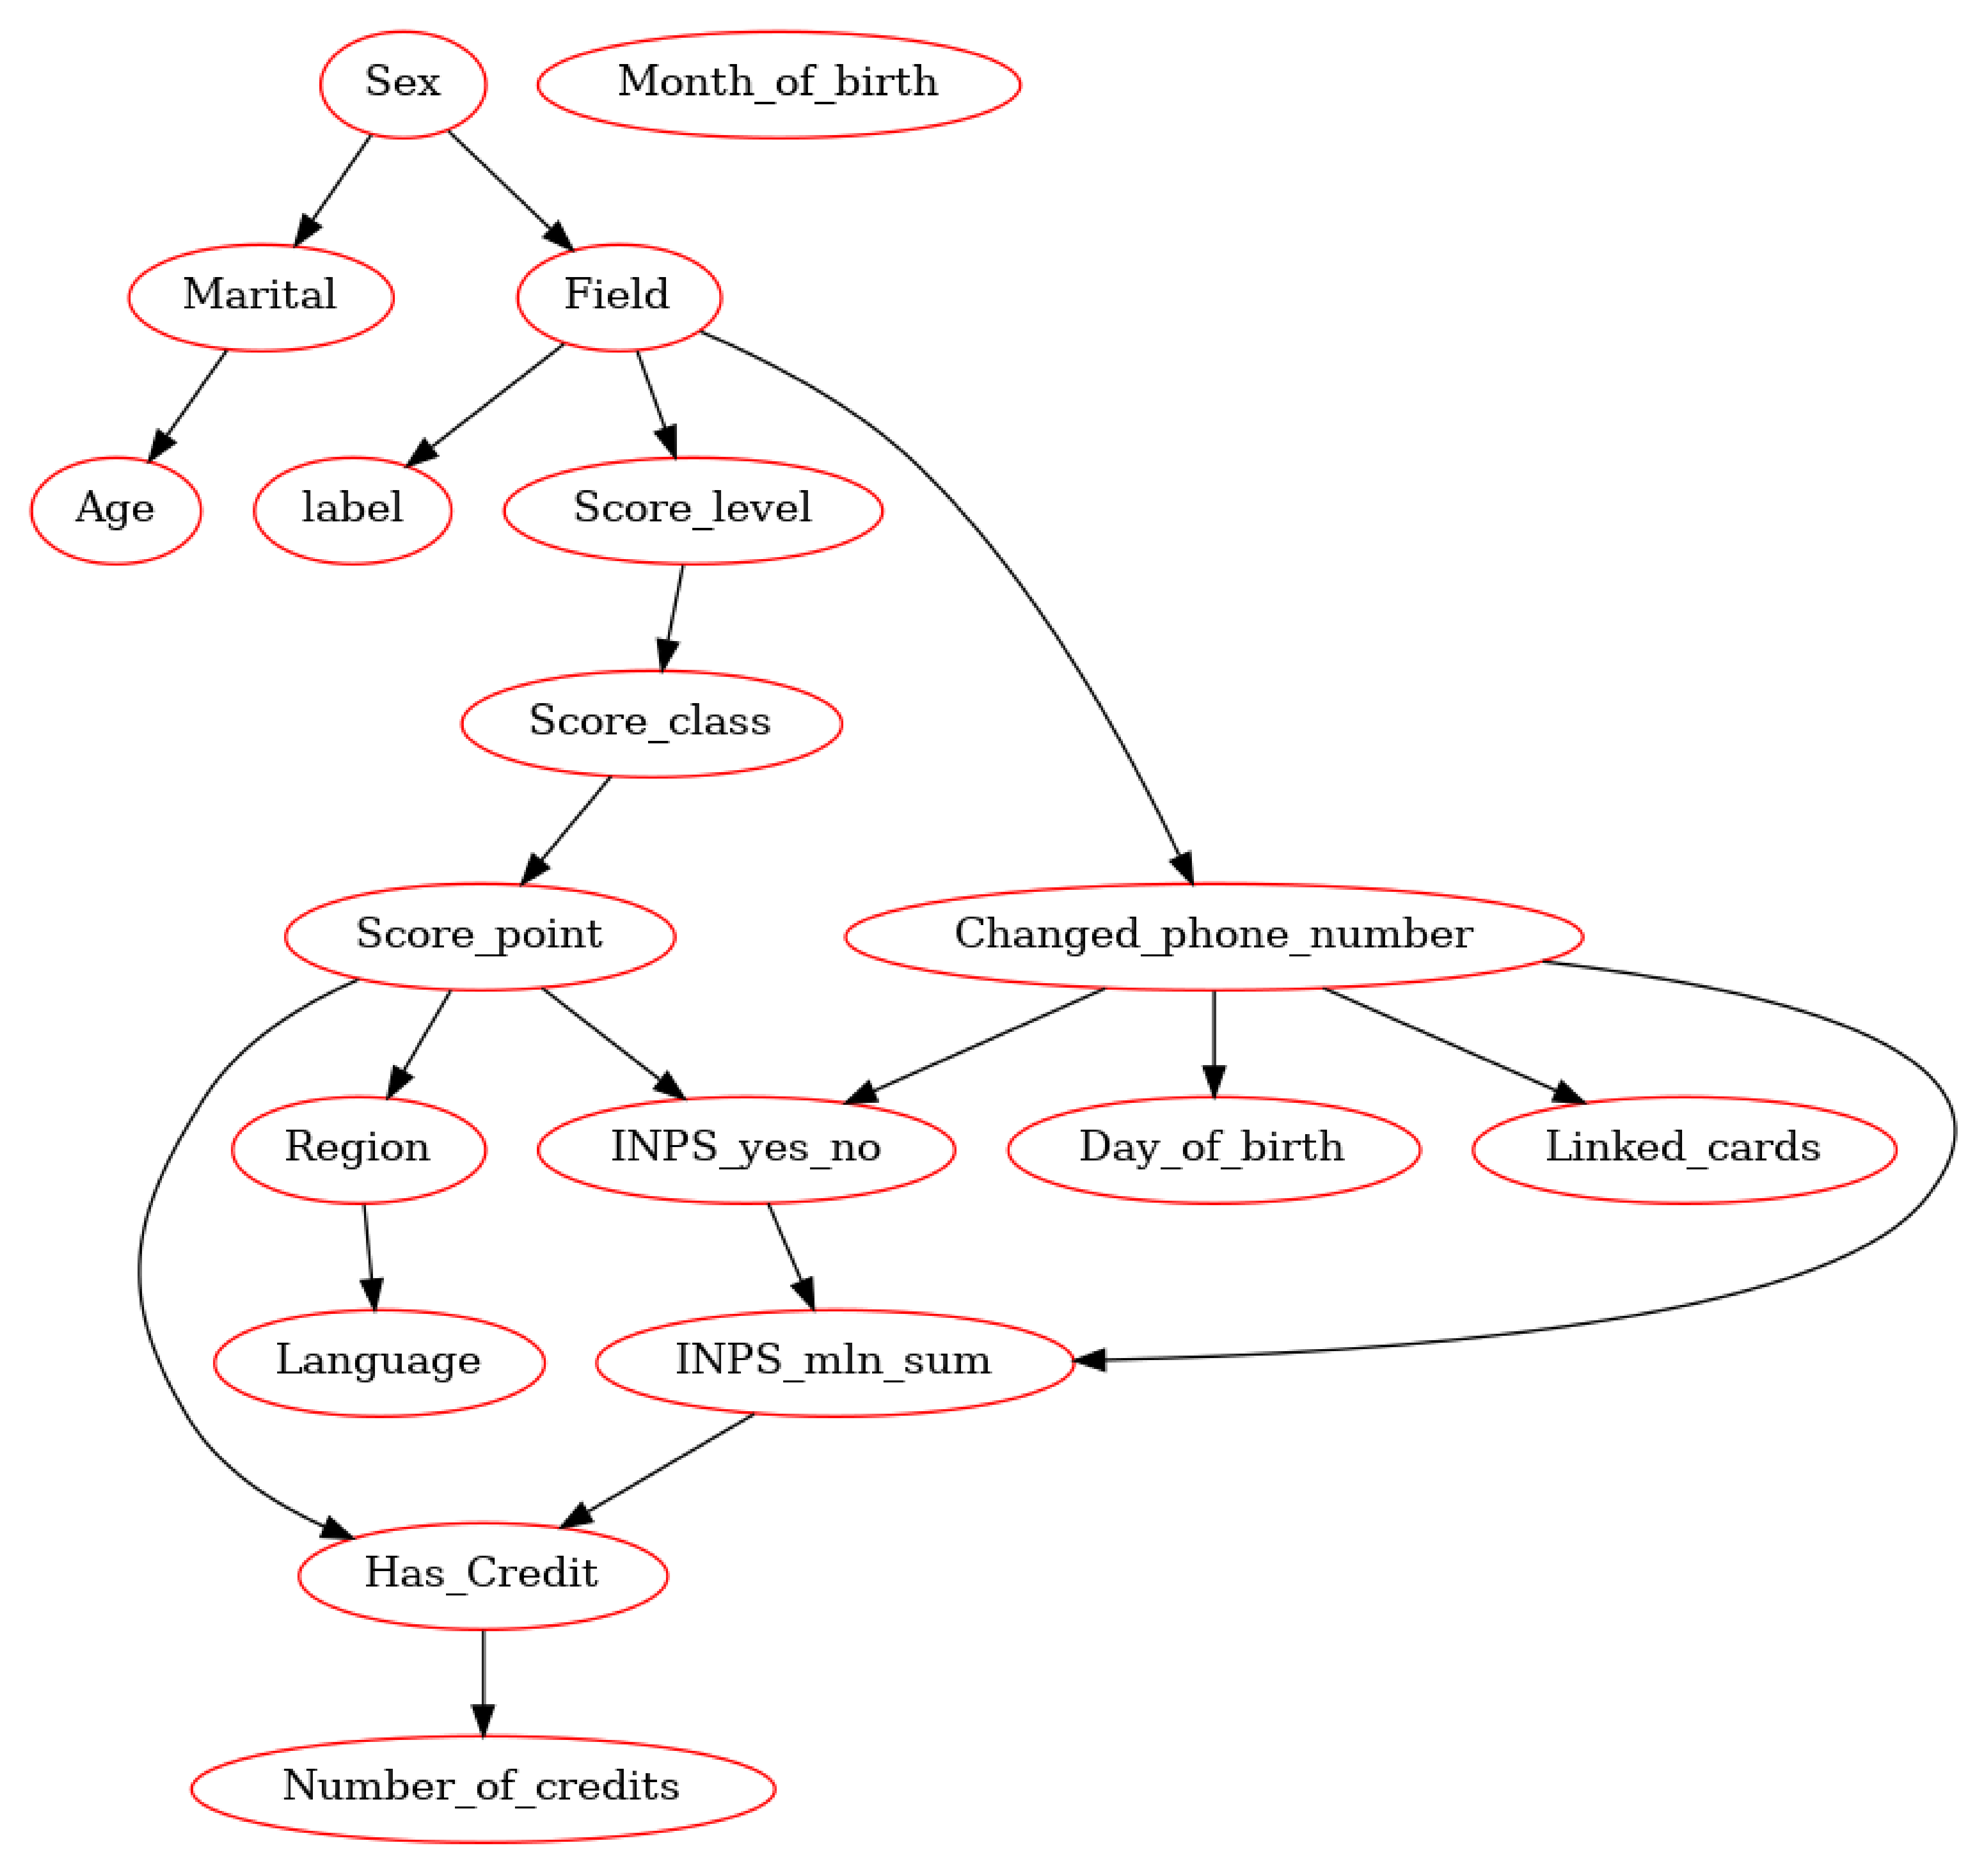

In [ ]:
a, X, labels = credit_scoring()
plot_bayesian_network(a, X, labels, 'Credit_scoring.BN.pdf')

0 Male
1 Age
2 Debt
3 Married
4 BankCustomer
5 EducationLevel
6 Ethnicity
7 YearsEmployed
8 PriorDefault
9 Employed
10 CreditScore
11 DriversLicense
12 Citizen
13 Income
14 Approved


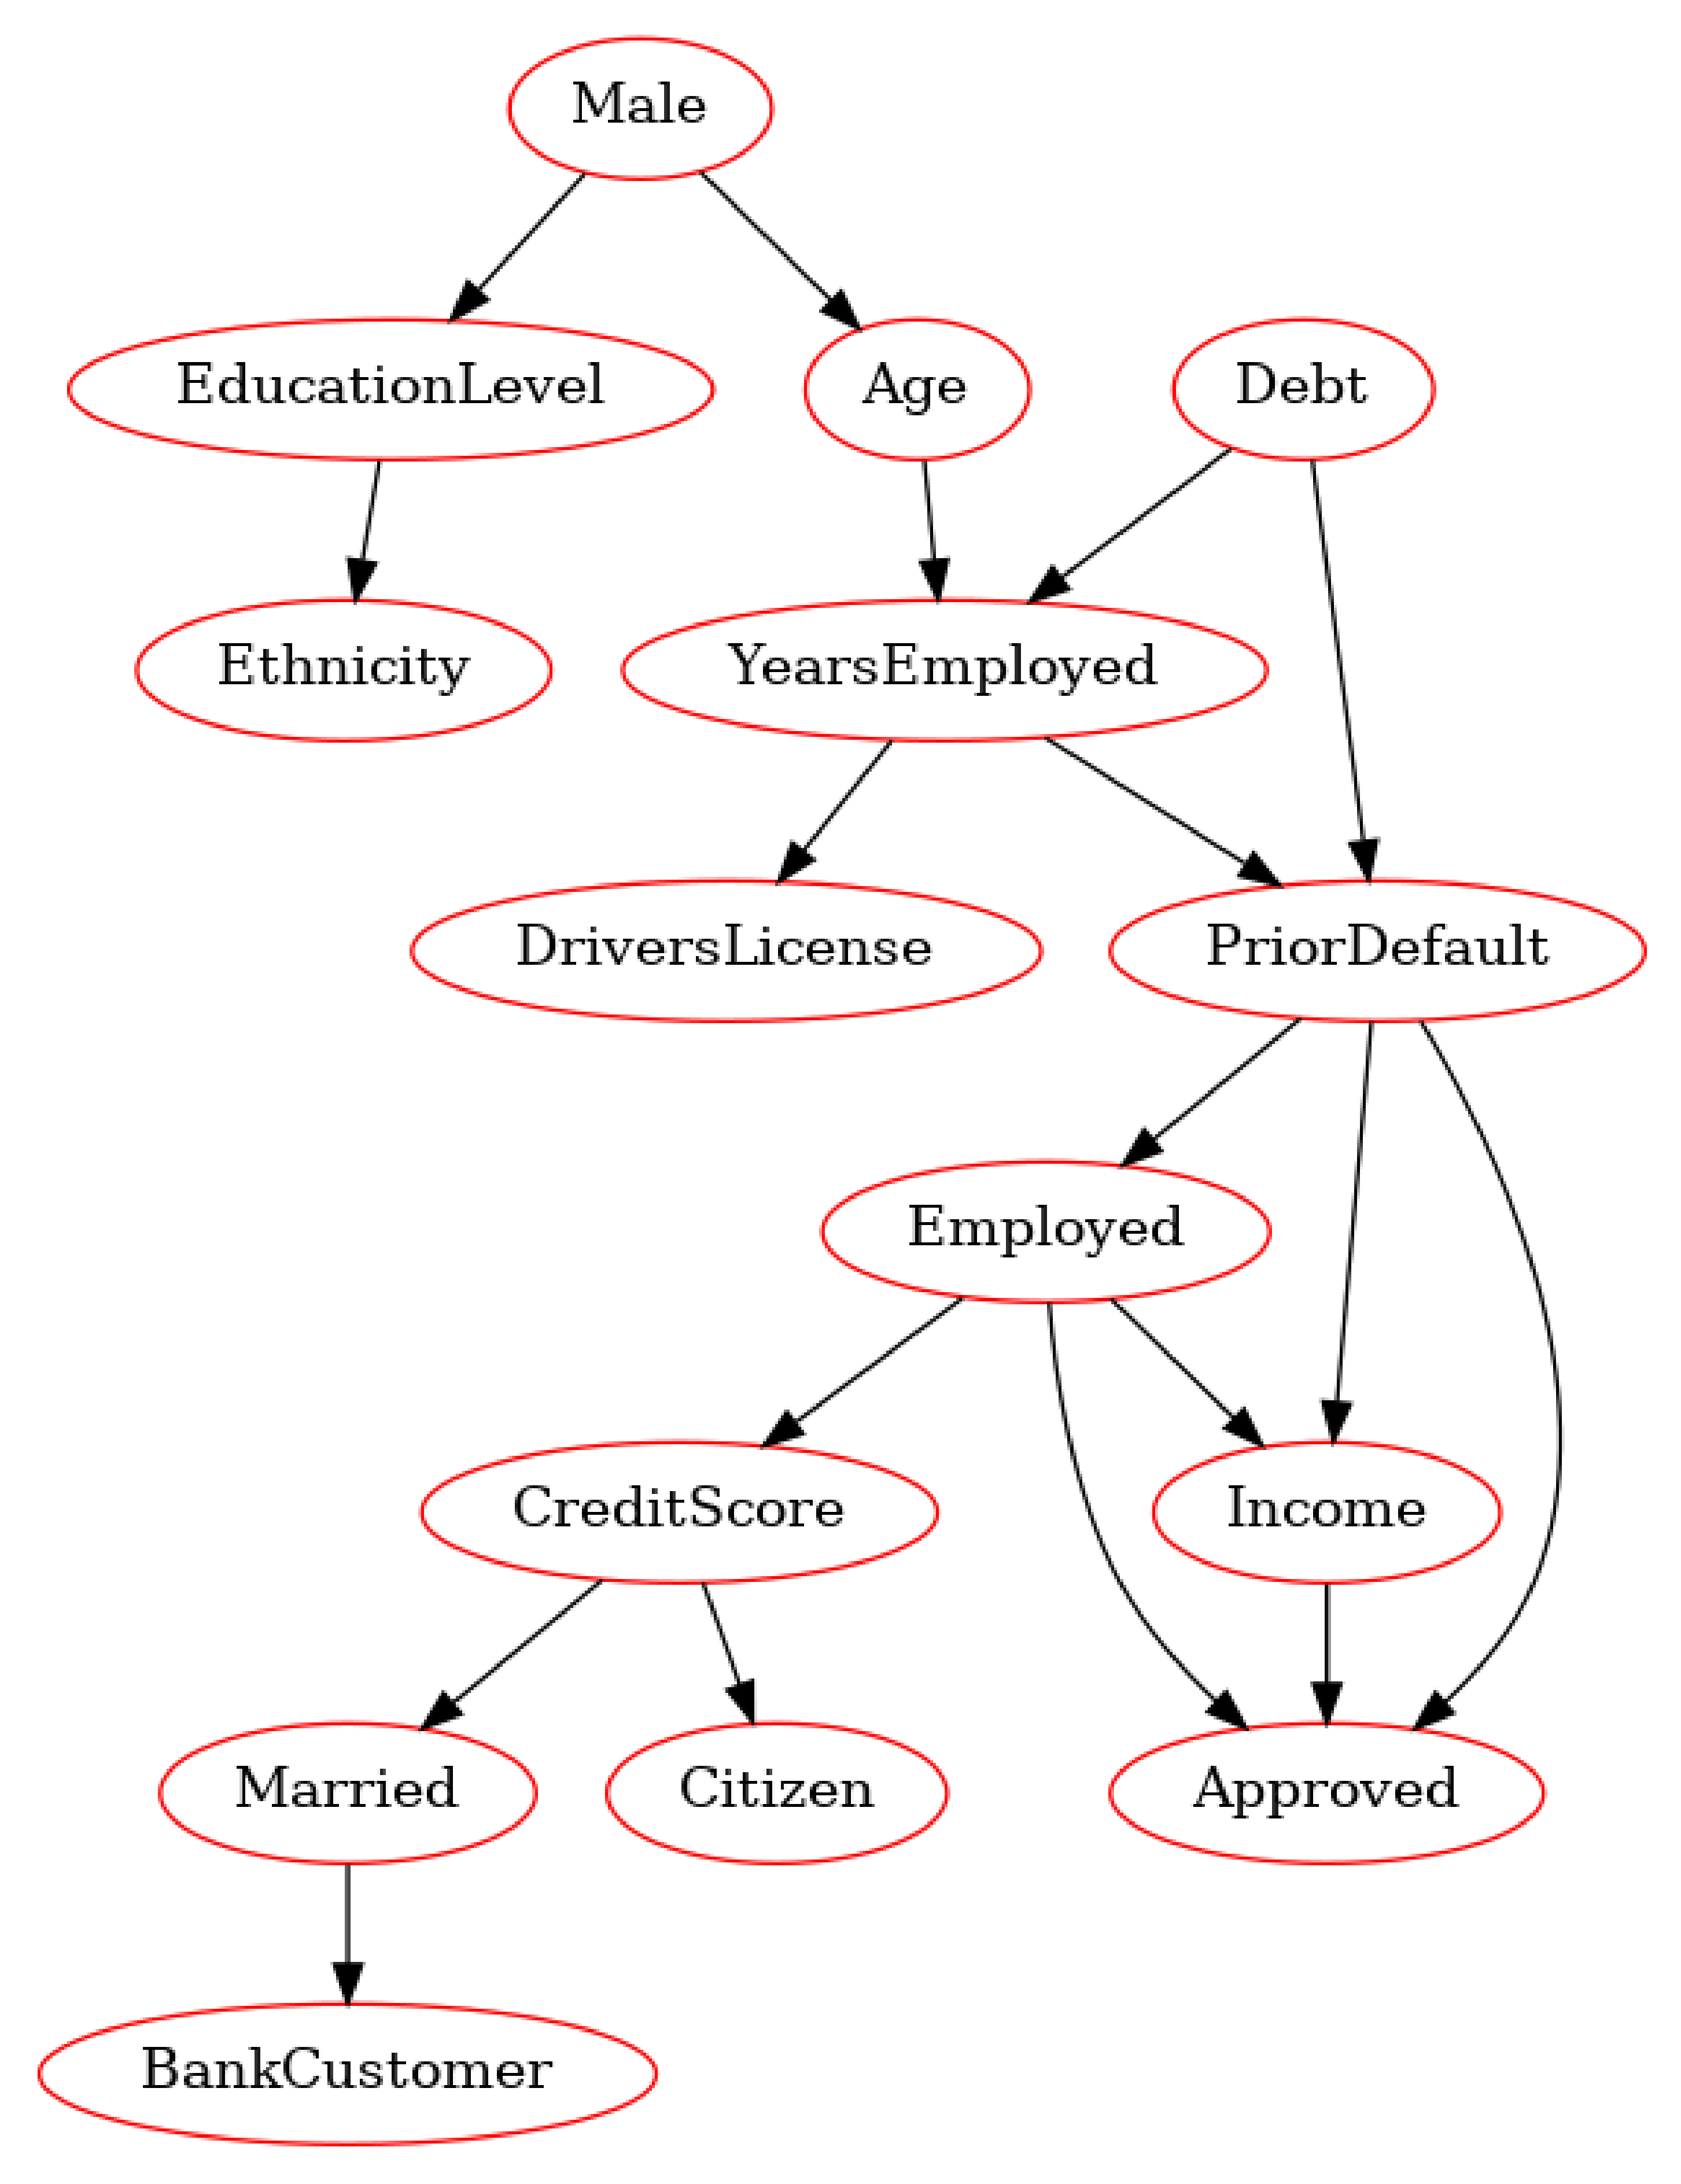

In [ ]:
a, X, labels = credit_approval()
plot_bayesian_network(a, X, labels, 'Credit_approval.BN.pdf')

0 LIMIT_BAL
1 SEX
2 EDUCATION
3 MARRIAGE
4 AGE
5 PAY_0
6 PAY_2
7 PAY_3
8 PAY_4
9 PAY_5
10 PAY_6
11 BILL_AMT1
12 BILL_AMT2
13 BILL_AMT3
14 BILL_AMT4
15 BILL_AMT5
16 BILL_AMT6
17 PAY_AMT1
18 PAY_AMT2
19 PAY_AMT3
20 PAY_AMT4
21 PAY_AMT5
22 PAY_AMT6
23 default payment


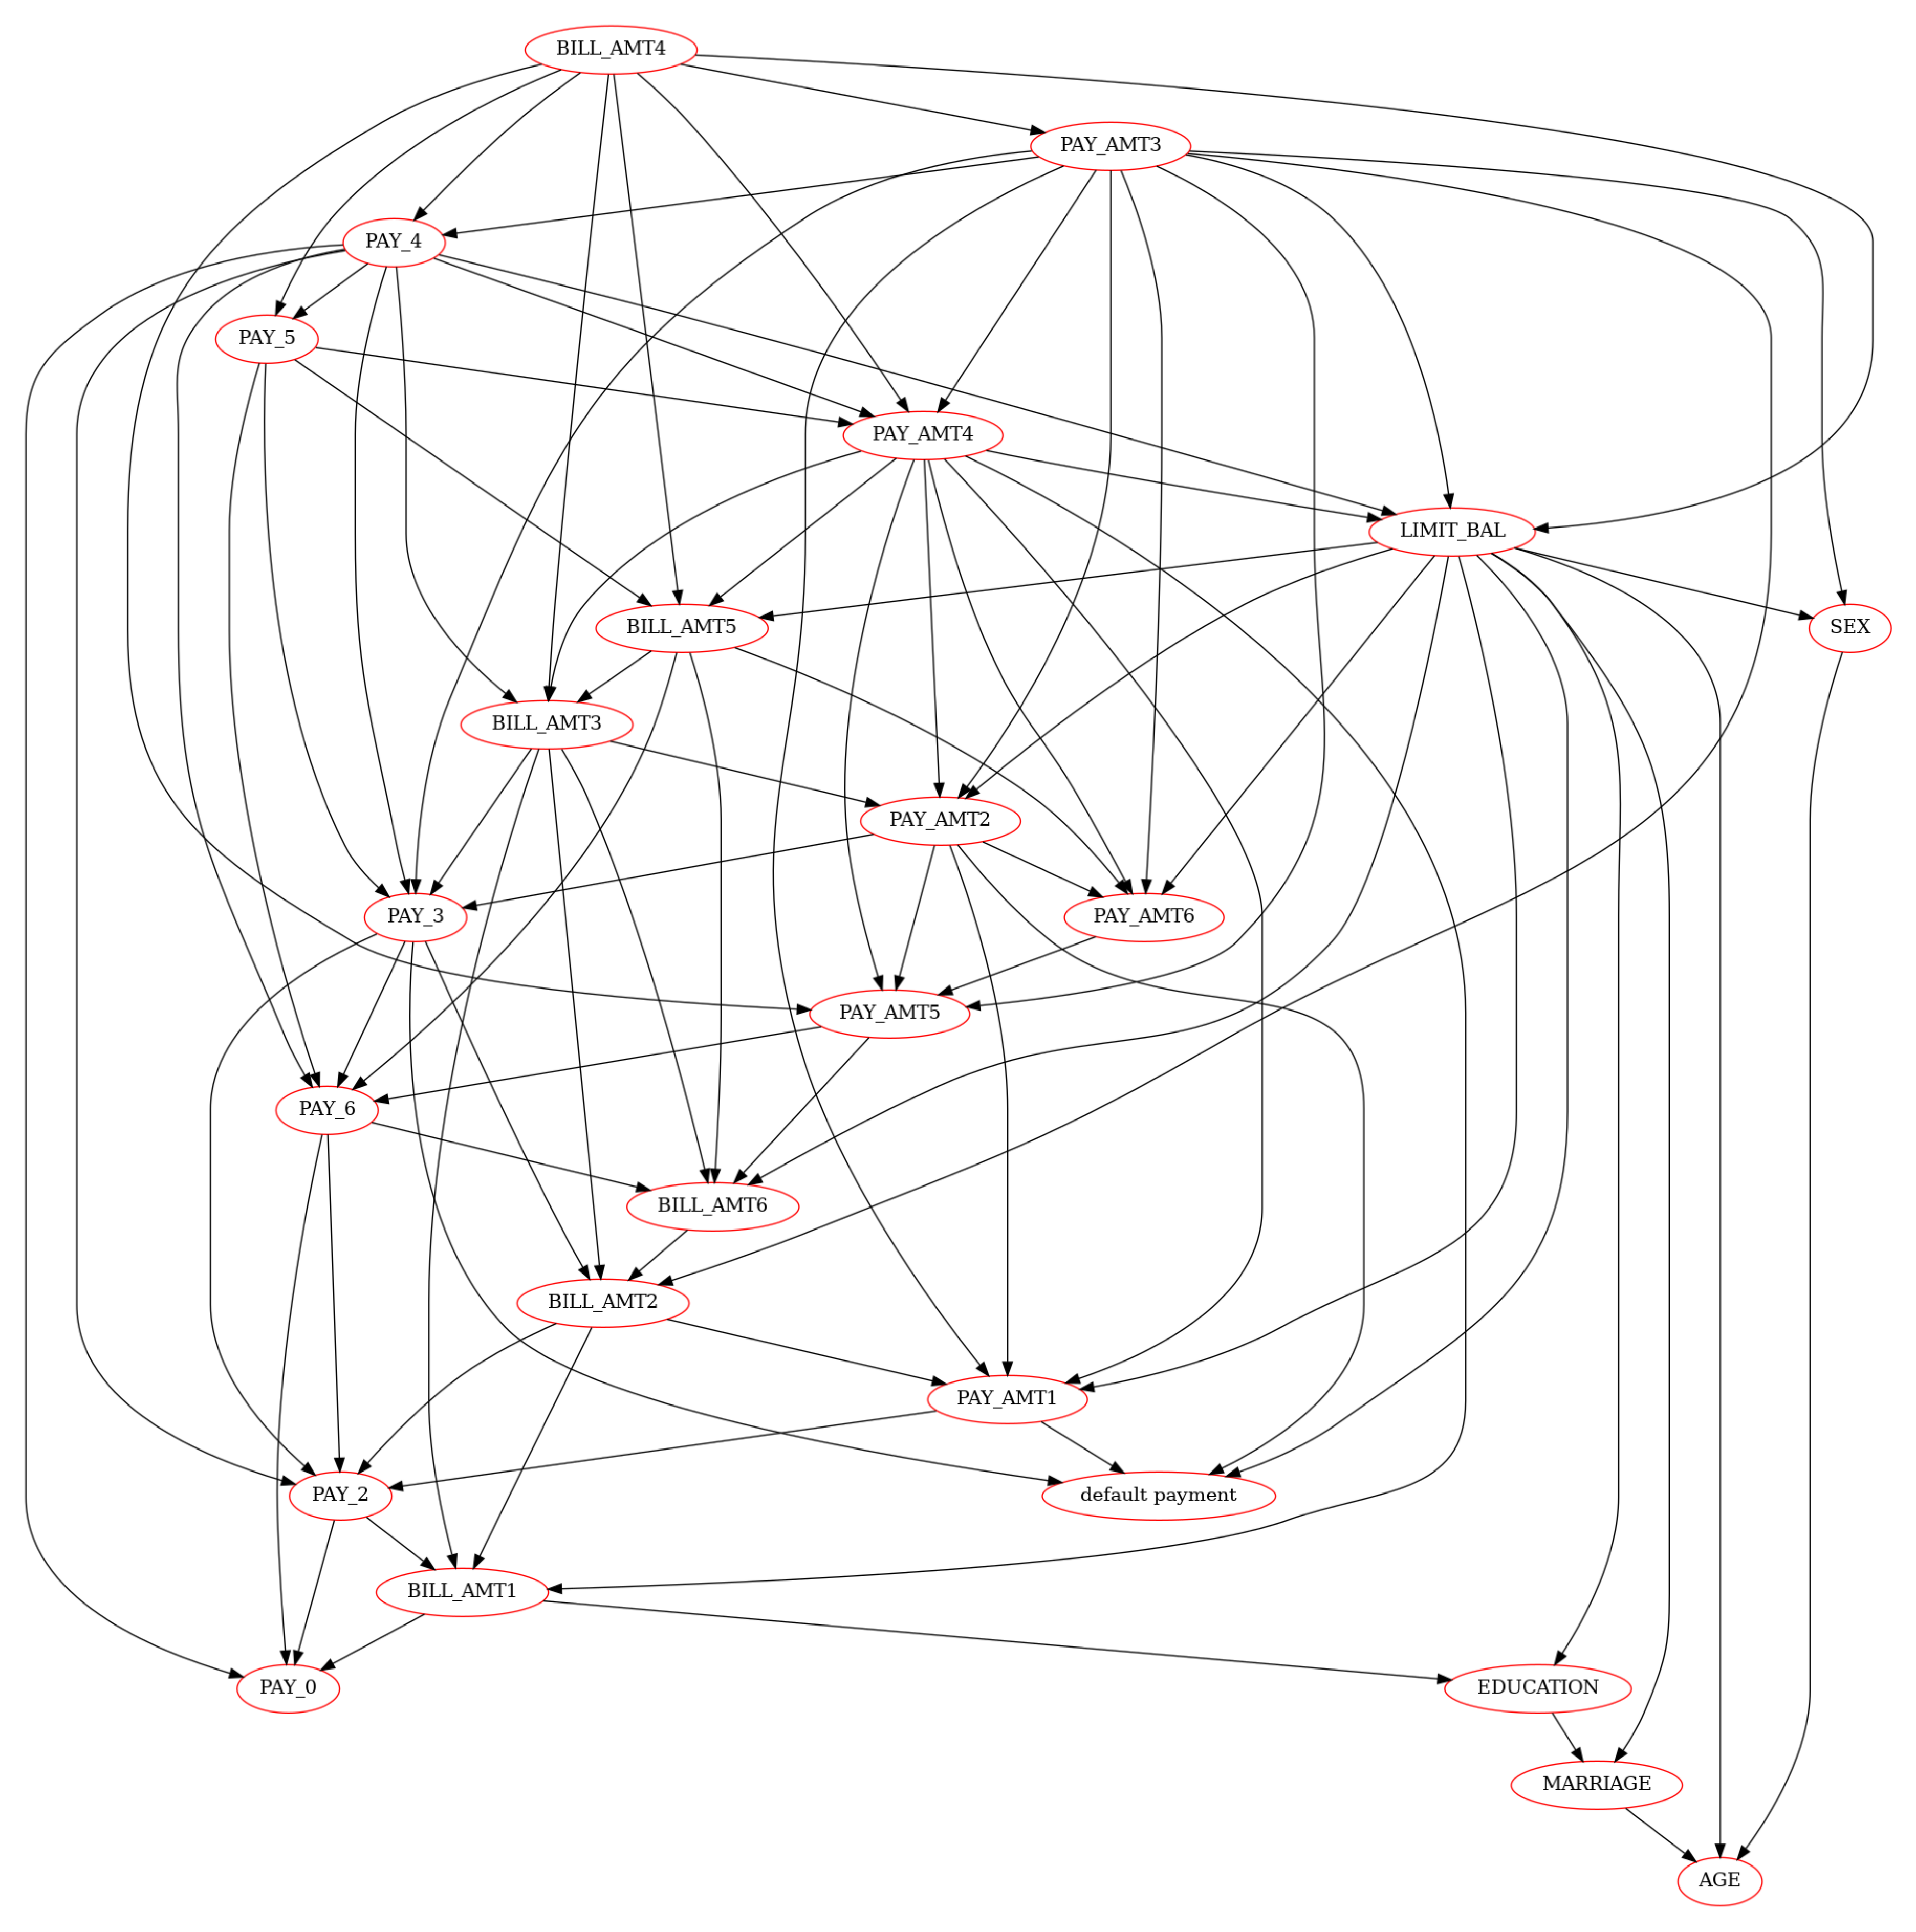

In [ ]:
a, X, labels = credit_card()
plot_bayesian_network(a, X, labels, 'Credit_card_clients.BN.pdf')

In [ ]:
a, X, labels = pakdd()
plot_bayesian_network(a, X, labels, 'PAKDD.BN.pdf')

/tmp/ipykernel_16349/3654071075.py:2: DtypeWarning: Columns (44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/PAKDD.csv')


0 PAYMENT_DAY 6
1 POSTAL_ADDRESS_TYPE 2
2 SEX 2
3 MARITAL_STATUS 8
4 QUANT_DEPENDANTS 16
5 NACIONALITY 3
6 FLAG_RESIDENCIAL_PHONE 2
7 RESIDENCE_TYPE 6
8 MONTHS_IN_RESIDENCE 88
9 FLAG_EMAIL 2
10 PERSONAL_MONTHLY_INCOME 4458
11 OTHER_INCOMES 543
12 FLAG_VISA 2
13 FLAG_MASTERCARD 2
14 FLAG_DINERS 2
15 FLAG_AMERICAN_EXPRESS 2
16 FLAG_OTHER_CARDS 2
17 QUANT_BANKING_ACCOUNTS 3
18 QUANT_SPECIAL_BANKING_ACCOUNTS 3
19 PERSONAL_ASSETS_VALUE 136
20 QUANT_CARS 2
21 COMPANY 2
22 FLAG_PROFESSIONAL_PHONE 2
23 MONTHS_IN_THE_JOB 19
24 OCCUPATION_TYPE 6
25 PRODUCT 3
26 AGE 87
27 TARGET_LABEL_BAD 2


: 

: 

In [4]:
a, X, labels = application()
plot_bayesian_network(a, X, labels, 'application.BN.pdf')

Length: 8602
0 TARGET 2
1 NAME_CONTRACT_TYPE 2
2 CODE_GENDER 2
3 FLAG_OWN_REALTY 2
4 CNT_CHILDREN 6
5 AMT_INCOME_TOTAL 266
6 AMT_CREDIT 1806
7 AMT_ANNUITY 3862
8 AMT_GOODS_PRICE 389
9 NAME_TYPE_SUITE 7
10 NAME_INCOME_TYPE 3
11 NAME_EDUCATION_TYPE 5
12 NAME_FAMILY_STATUS 5
13 NAME_HOUSING_TYPE 6
14 REGION_POPULATION_RELATIVE 78
15 DAYS_BIRTH 6103
16 DAYS_EMPLOYED 4288
17 OWN_CAR_AGE 47
18 OCCUPATION_TYPE 18
19 CNT_FAM_MEMBERS 7
20 REGION_RATING_CLIENT 3
21 REGION_RATING_CLIENT_W_CITY 3
22 ORGANIZATION_TYPE 55
